# Enron Scandal: Indentifying Person of Interest

**Identification of Enron employees who may have committed fraud**

**Supervised Learning. Classification**

Data: [Enron financial dataset from Udacity](https://github.com/udacity/ud120-projects/tree/master/final_project)

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helper
import keras

helper.info_gpu()
#sns.set_palette("Reds")
helper.reproducible(seed=0)  # setup reproducible results from run to run using Keras

%matplotlib inline

/device:GPU:0
Keras		v2.1.3
TensorFlow	v1.4.1


## 1. Data Processing and Exploratory Data Analysis

In [18]:
data_path = 'data/enron_financial_data.pkl'
target = ['poi']

df = pd.read_pickle(data_path)
df = pd.DataFrame.from_dict(df, orient='index')
print("rows: {} \ncolumns: {} \ntarget: {}".format(*df.shape, target))

rows: 146 
columns: 21 
target: ['poi']


**poi** =  person of interest (boolean) <br>

### Explore the target

In [19]:
print(df[target].squeeze().value_counts(dropna=False))

False    128
True      18
Name: poi, dtype: int64


** Imbalanced target: the evaluation metric used in this problem is the Area Under the ROC Curve **

### Show the data

In [20]:
df.head(3)

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
ALLEN PHILLIP K,201955,2902,2869717,4484442,NaN,4175000,phillip.allen@enron.com,-126027,-3081055,1729541,...,47,1729541,2195,152,65,False,304805,1407,126027,NaN
BADUM JAMES P,NaN,NaN,178980,182466,NaN,NaN,NaN,NaN,NaN,257817,...,NaN,257817,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,NaN,NaN,james.bannantine@enron.com,-560222,-5104,5243487,...,39,4046157,29,864523,0,False,NaN,465,1757552,NaN


### Transform the data

In [21]:
# delete 'TOTAL' row (at the bottom)
if 'TOTAL' in df.index:
    df.drop('TOTAL', axis='index', inplace=True)

# convert dataframe values (objects) to numerical. There are no categorical features
df = df.apply(pd.to_numeric, errors='coerce')

#### Missing features

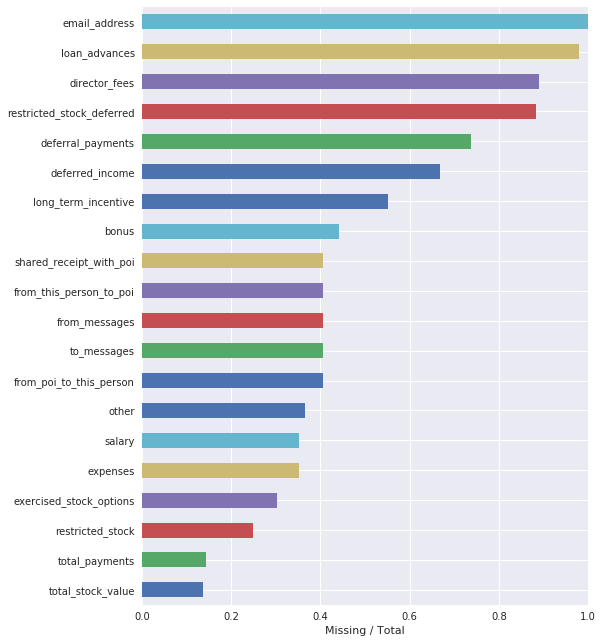

In [22]:
helper.missing(df)

High-missing values, like 'loan_advances', are needed for obtain better models

#### Remove irrelevant features

In [23]:
df.drop('email_address', axis='columns', inplace=True)

#### Classify variables

In [24]:
num = list(df.select_dtypes(include=[np.number]))

df = helper.classify_data(df, target, numerical=num)

pd.DataFrame(dict(df.dtypes), index=["Type"])[df.columns].head()  # show data types

numerical features:   19
categorical features: 0
target 'poi': category


,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees,poi
Type,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,category


#### Fill missing values

In [25]:
# Reeplace NaN values with the median
df.fillna(df.median(), inplace=True)
#helper.fill_simple(df, target, inplace=True) # same result

### Visualize the data

In [26]:
df.describe(percentiles=[0.5])

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
count,1.450000e+02,145.000000,1.450000e+02,145.0,145.00,145.00,1.450000e+02,1.450000e+02,145.00,145.000000,145.000000,145.00,145.000000,1.450000e+02,145.000000,145.000,145.000000,1.450000e+02,145.000000
mean,2.751726e+05,1722.765503,3.836875e+05,2402823.5,2537413.75,1002369.75,-5.090768e+04,-2.939815e+05,3040758.25,51503.250000,52.731033,2455073.25,377.758606,3.142112e+05,27.710344,567548.750,999.072388,9.720599e+05,104361.281250
std,1.428664e+05,2029.355103,7.086024e+05,8785497.0,6606450.50,1097889.50,1.305242e+06,5.750959e+05,6112358.00,37235.035156,68.431458,4646612.00,1441.885376,1.122664e+06,78.611641,597613.875,930.455933,1.972272e+06,14229.056641
min,4.770000e+02,57.000000,-1.025000e+05,148.0,400000.00,70000.00,-1.787380e+06,-3.504386e+06,-44093.00,148.000000,0.000000,3285.00,12.000000,2.000000e+00,0.000000,69223.000,2.000000,-2.604490e+06,3285.000000
50%,2.587410e+05,1211.000000,2.210635e+05,1100246.5,2000000.00,750000.00,-1.402640e+05,-1.519270e+05,1095040.00,46547.500000,35.000000,1297049.00,41.000000,5.198450e+04,8.000000,422158.000,740.500000,4.410960e+05,106164.500000
max,1.111258e+06,15149.000000,6.426990e+06,103559792.0,81525000.00,8000000.00,1.545629e+07,-8.330000e+02,49110080.00,228763.000000,528.000000,34348384.00,14368.000000,1.035973e+07,609.000000,5145434.000,5521.000000,1.476169e+07,137864.000000


#### Numerical features

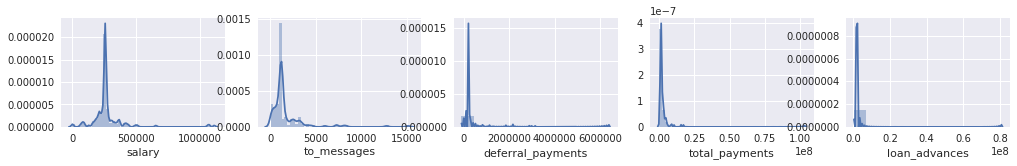

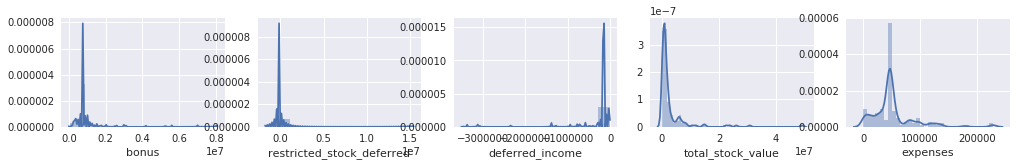

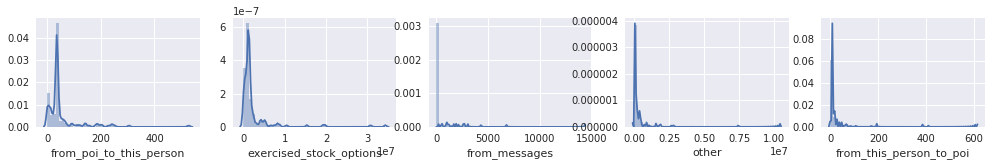

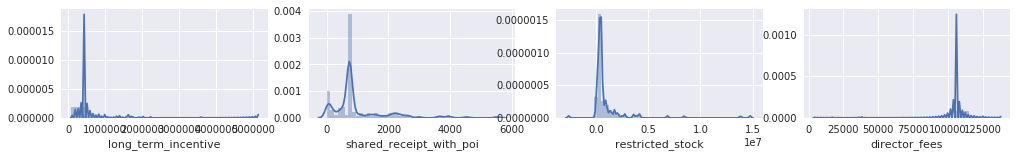

In [27]:
helper.show_numerical(df.iloc[:, :5], kde=True)
helper.show_numerical(df.iloc[:, 5:10], kde=True)
helper.show_numerical(df.iloc[:, 10:15], kde=True)
helper.show_numerical(df.iloc[:, 15:], kde=True)

#### Target vs Numerical features

(-0.2, 1.2)

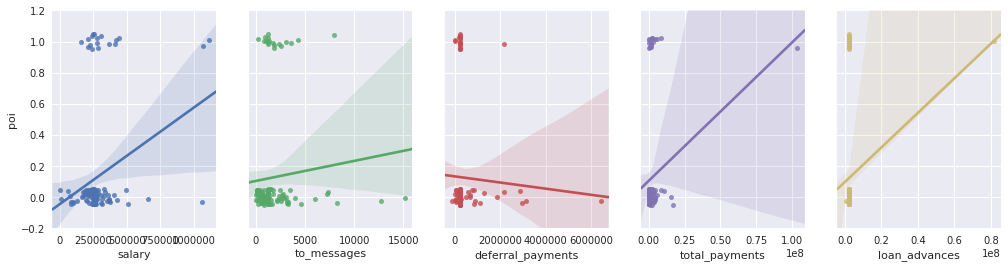

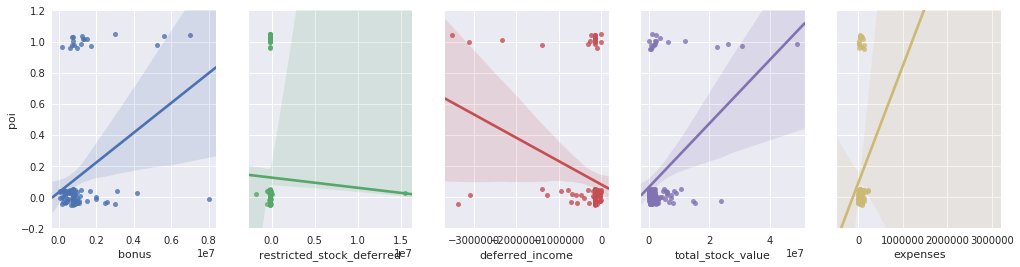

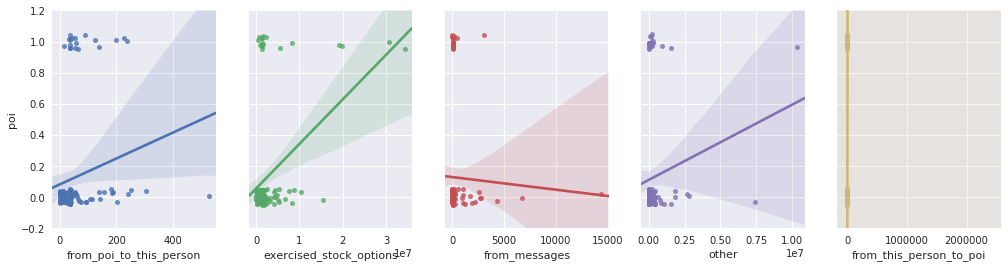

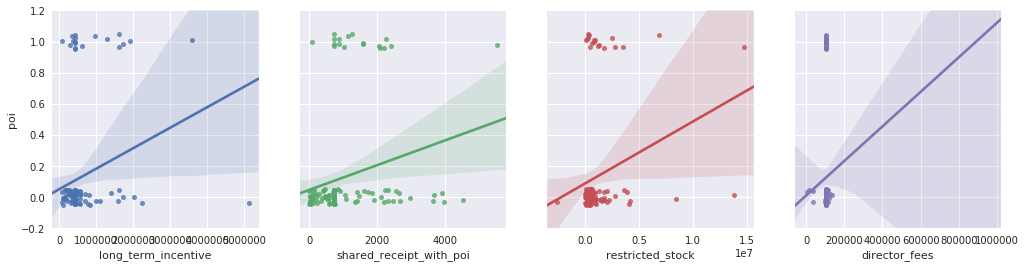

In [28]:
helper.show_target_vs_numerical(
    df.iloc[:, :5].join(df[target]), target, jitter=0.05, fit_reg=True, point_size=100)
plt.ylim(ymin=-0.2, ymax=1.2)
helper.show_target_vs_numerical(
    df.iloc[:, 5:10].join(df[target]), target, jitter=0.05, fit_reg=True, point_size=100)
plt.ylim(ymin=-0.2, ymax=1.2)
helper.show_target_vs_numerical(
    df.iloc[:, 10:15].join(df[target]), target, jitter=0.05, fit_reg=True, point_size=100)
plt.ylim(ymin=-0.2, ymax=1.2)
helper.show_target_vs_numerical(
    df.iloc[:, 15:], target, jitter=0.05, fit_reg=True, point_size=100)
plt.ylim(ymin=-0.2, ymax=1.2)

#### Total stock value vs some features 

(0, 50000000.0)

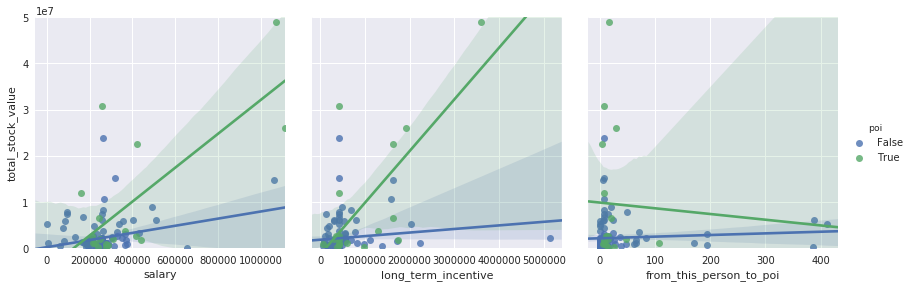

In [29]:
# df.plot.scatter(x='salary', y='total_stock_value')
# df.plot.scatter(x='long_term_incentive', y='total_stock_value')

# sns.lmplot(x="salary", y="total_stock_value", hue='poi', data=df)
# sns.lmplot(x="long_term_incentive", y="total_stock_value", hue='poi', data=df)

g = sns.PairGrid(
    df,
    y_vars=["total_stock_value"],
    x_vars=["salary", "long_term_incentive", "from_this_person_to_poi"],
    hue='poi',
    size=4)
g.map(sns.regplot).add_legend()
plt.ylim(ymin=0, ymax=0.5e8)

#sns.pairplot(df, hue='poi', vars=['long_term_incentive', 'total_stock_value', 'from_poi_to_this_person'], kind='reg', size=3)

The person of interest seems to have a higher stock vs salary and long-term incentive, especially when his stock value is high. There is no dependency between POI and the amount of emails from or to another person of interest.

#### Correlation between numerical features and target

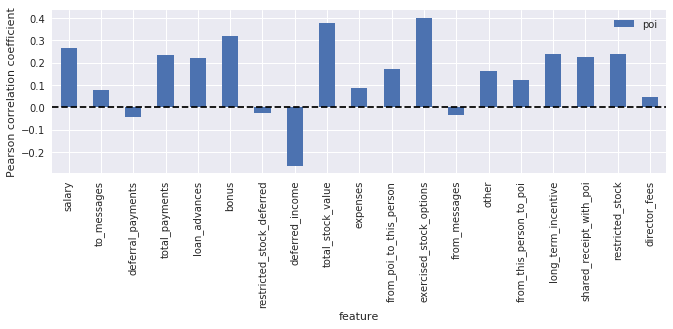

In [30]:
helper.show_correlation(df, target, figsize=(11,3))

## 2. Neural Network model

### Select the features

In [15]:
droplist = []  # features to drop from the model

# For the model 'data' instead of 'df'
data = df.copy()
data.drop(droplist, axis='columns', inplace=True)
data.head(3)

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees,poi
ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,2000000.0,4175000.0,-126027.0,-3081055.0,1729541.0,13868.0,47.0,1729541.0,2195.0,152.0,65.0,304805.0,1407.0,126027.0,106164.5,False
BADUM JAMES P,258741.0,1211.0,178980.0,182466.0,2000000.0,750000.0,-140264.0,-151927.0,257817.0,3486.0,35.0,257817.0,41.0,51984.5,8.0,422158.0,740.5,441096.0,106164.5,False
BANNANTINE JAMES M,477.0,566.0,221063.5,916197.0,2000000.0,750000.0,-560222.0,-5104.0,5243487.0,56301.0,39.0,4046157.0,29.0,864523.0,0.0,422158.0,465.0,1757552.0,106164.5,False


### Scale numerical features
Shift and scale numerical variables to a standard normal distribution. The scaling factors are saved to be used for predictions.

In [16]:
data, scale_param = helper.scale(data)

There are no categorical variables

### Split the data into training and test sets
Data leakage: Test set hidden when training the model, but seen when preprocessing the dataset

No validation set (small dataset)

In [17]:
test_size = 0.4
random_state = 9

from sklearn.model_selection import train_test_split

train, test = train_test_split(
    data, test_size=test_size, random_state=random_state, stratify=df[target])

# Separate the data into features and targets (x=features, y=targets)
x_train, y_train_nc = train.drop(target, axis=1).values, train[target].values
x_test, y_test_nc = test.drop(target, axis=1).values, test[target].values
# _nc: non-categorical yet

### Encode the output

In [18]:
def one_hot_output(y_train, y_test):
    num_classes = len(np.unique(y_train))
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    return y_train, y_test


y_train, y_test = one_hot_output(y_train_nc, y_test_nc)

In [19]:
print("train size \t X:{} \t Y:{}".format(x_train.shape, y_train.shape))
print("test size  \t X:{} \t Y:{} ".format(x_test.shape, y_test.shape))

train size 	 X:(87, 19) 	 Y:(87, 2)
test size  	 X:(58, 19) 	 Y:(58, 2) 


### Build a dummy classifier

In [20]:
%load_ext autoreload
%autoreload 2

from sklearn.dummy import DummyClassifier

clf = DummyClassifier(strategy='most_frequent').fit(x_train, np.ravel(y_train))
# Therefore the dummy 'most_frequent' classifier always predicts class 0 (NO SPAM)
y_pred = clf.predict(x_test).reshape([-1, 1])

helper.binary_classification_scores(y_test[:, 1], y_pred)

Test scores:
-----------
Loss (log_loss): 	4.1685
Accuracy: 	0.88
Precision: 	0.00
Recall: 	0.00
ROC AUC: 	0.00
F1-score: 	0.00

Confusion matrix: 
 [[51  0]
 [ 7  0]]


(4.168473013178876, 0.8793103448275862, 0.0, 0, 0, 0)

### Build the Neural Network  for Binary Classification

In [21]:
# class weight for imbalance target

from sklearn.utils import class_weight

y_plain = np.ravel(y_train[:, 1])

cw = class_weight.compute_class_weight('balanced', np.unique(y_plain), y_plain)

cw = {idx: value for idx, value in enumerate(cw)}

In [32]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras import regularizers


def build_nn(input_size, output_size, summary=False):

    input_nodes = input_size
    weights = keras.initializers.RandomNormal(stddev=0.00001)

    model = Sequential()
    model.add(
        Dense(
            input_nodes,
            input_dim=x_train.shape[1],
            activation='relu',

            bias_initializer='zero'))
    model.add(Dropout(0.3))
    model.add(
        Dense(
            2,
            activation='softmax',

            bias_initializer='zero'))

    opt = keras.optimizers.adam()
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    if summary:
        model.summary()

    return model


model = build_nn(x_train.shape[1], y_train.shape[1], summary=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 19)                380       
_________________________________________________________________
dropout_6 (Dropout)          (None, 19)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 40        
Total params: 420
Trainable params: 420
Non-trainable params: 0
_________________________________________________________________


Training ....
time: 	 0.7 s


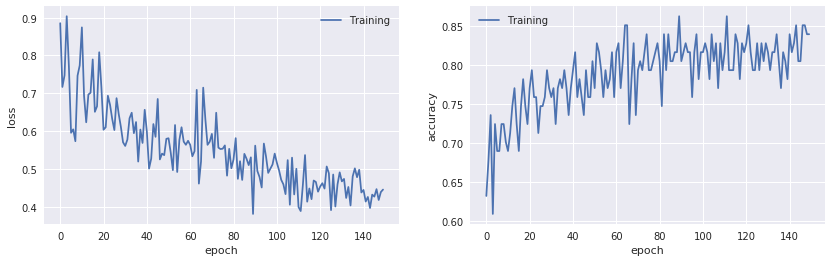


Training loss:  	0.4452

Training accuracy: 	0.839

Model saved at models/enron_scandal.h5

ROC_AUC train:	0.91 



In [33]:
from time import time
model_path = os.path.join("models", "enron_scandal.h5")


def train_nn(model, x_train, y_train, validation_data=None, path=False, show=True):
    """ 
    Train the neural network model. If no validation_data is provided, a split for validation
    will be used
    """
    
    if show:
        print('Training ....')
    
    #callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, verbose=0)]
    t0 = time()

    history = model.fit(
        x_train,
        y_train,
        epochs=150,
        batch_size=128,              
        verbose=0,
        class_weight=cw,
        # validation_split=0,
        # validation_data = validation_data,
        # callbacks=callbacks
    )

    if show:
        print("time: \t {:.1f} s".format(time() - t0))
        helper.show_training(history)

    if path:
        model.save(path)
        print("\nModel saved at", path)
    
    return history
        

model = None
model = build_nn(x_train.shape[1], y_train.shape[1], summary=False)
train_nn(model, x_train, y_train, path=model_path);

from sklearn.metrics import roc_auc_score
y_pred_train = model.predict(x_train, verbose=0)
print('\nROC_AUC train:\t{:.2f} \n'.format(roc_auc_score(y_train, y_pred_train)))


### Evaluate the model

In [34]:
# Dataset too small for train, validation, and test sets. More data is needed for a proper
%load_ext autoreload
% autoreload 2

y_pred = model.predict(x_test, verbose=0)

helper.binary_classification_scores(y_test[:, 1], y_pred[:, 1]);

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Test scores:
-----------
Loss (log_loss): 	0.4820
Accuracy: 	0.84
Precision: 	0.42
Recall: 	0.71
ROC AUC: 	0.80
F1-score: 	0.53

Confusion matrix: 
 [[44  7]
 [ 2  5]]


### Compare with non-neural network models

In [35]:
helper.ml_classification(x_train, y_train[:,1], x_test, y_test[:,1])

Naive Bayes
Decision Tree
KNeighbors
AdaBoost
Random Forest


,Time (s),Loss,Accuracy,Precision,Recall,ROC-AUC,F1-score
KNeighbors,0.00,1.98,0.88,0.00,0.00,0.00,0.00
Decision Tree,0.00,5.36,0.84,0.38,0.43,0.67,0.40
Random Forest,0.09,0.30,0.83,0.00,0.00,0.00,0.00
AdaBoost,0.05,0.50,0.81,0.25,0.29,0.73,0.27
Naive Bayes,0.00,4.88,0.74,0.25,0.57,0.83,0.35
